In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

In [25]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [26]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

In [27]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [34]:
# Apply TruncatedSVD-based imputation on X_train
svd = TruncatedSVD(n_components=3)  # n_components specifies the number of latent factors (rank)
X_train_imputed = svd.fit_transform(np.nan_to_num(X_train))  # Fit and transform X_train (filling NaNs with 0)

# Reconstruct X_train with imputed values
X_train_imputed_reconstructed = svd.inverse_transform(X_train_imputed)

# Apply TruncatedSVD-based imputation on X_test using the same SVD model fitted on X_train
X_test_imputed = svd.transform(np.nan_to_num(X_test))  # Transform X_test (filling NaNs with 0)

# Reconstruct X_test with imputed values
X_test_imputed_reconstructed = svd.inverse_transform(X_test_imputed)

# Convert imputed data back into DataFrames
X_train_imputed_df = pd.DataFrame(X_train_imputed_reconstructed, columns=X_train.columns)
X_test_imputed_df = pd.DataFrame(X_test_imputed_reconstructed, columns=X_test.columns)

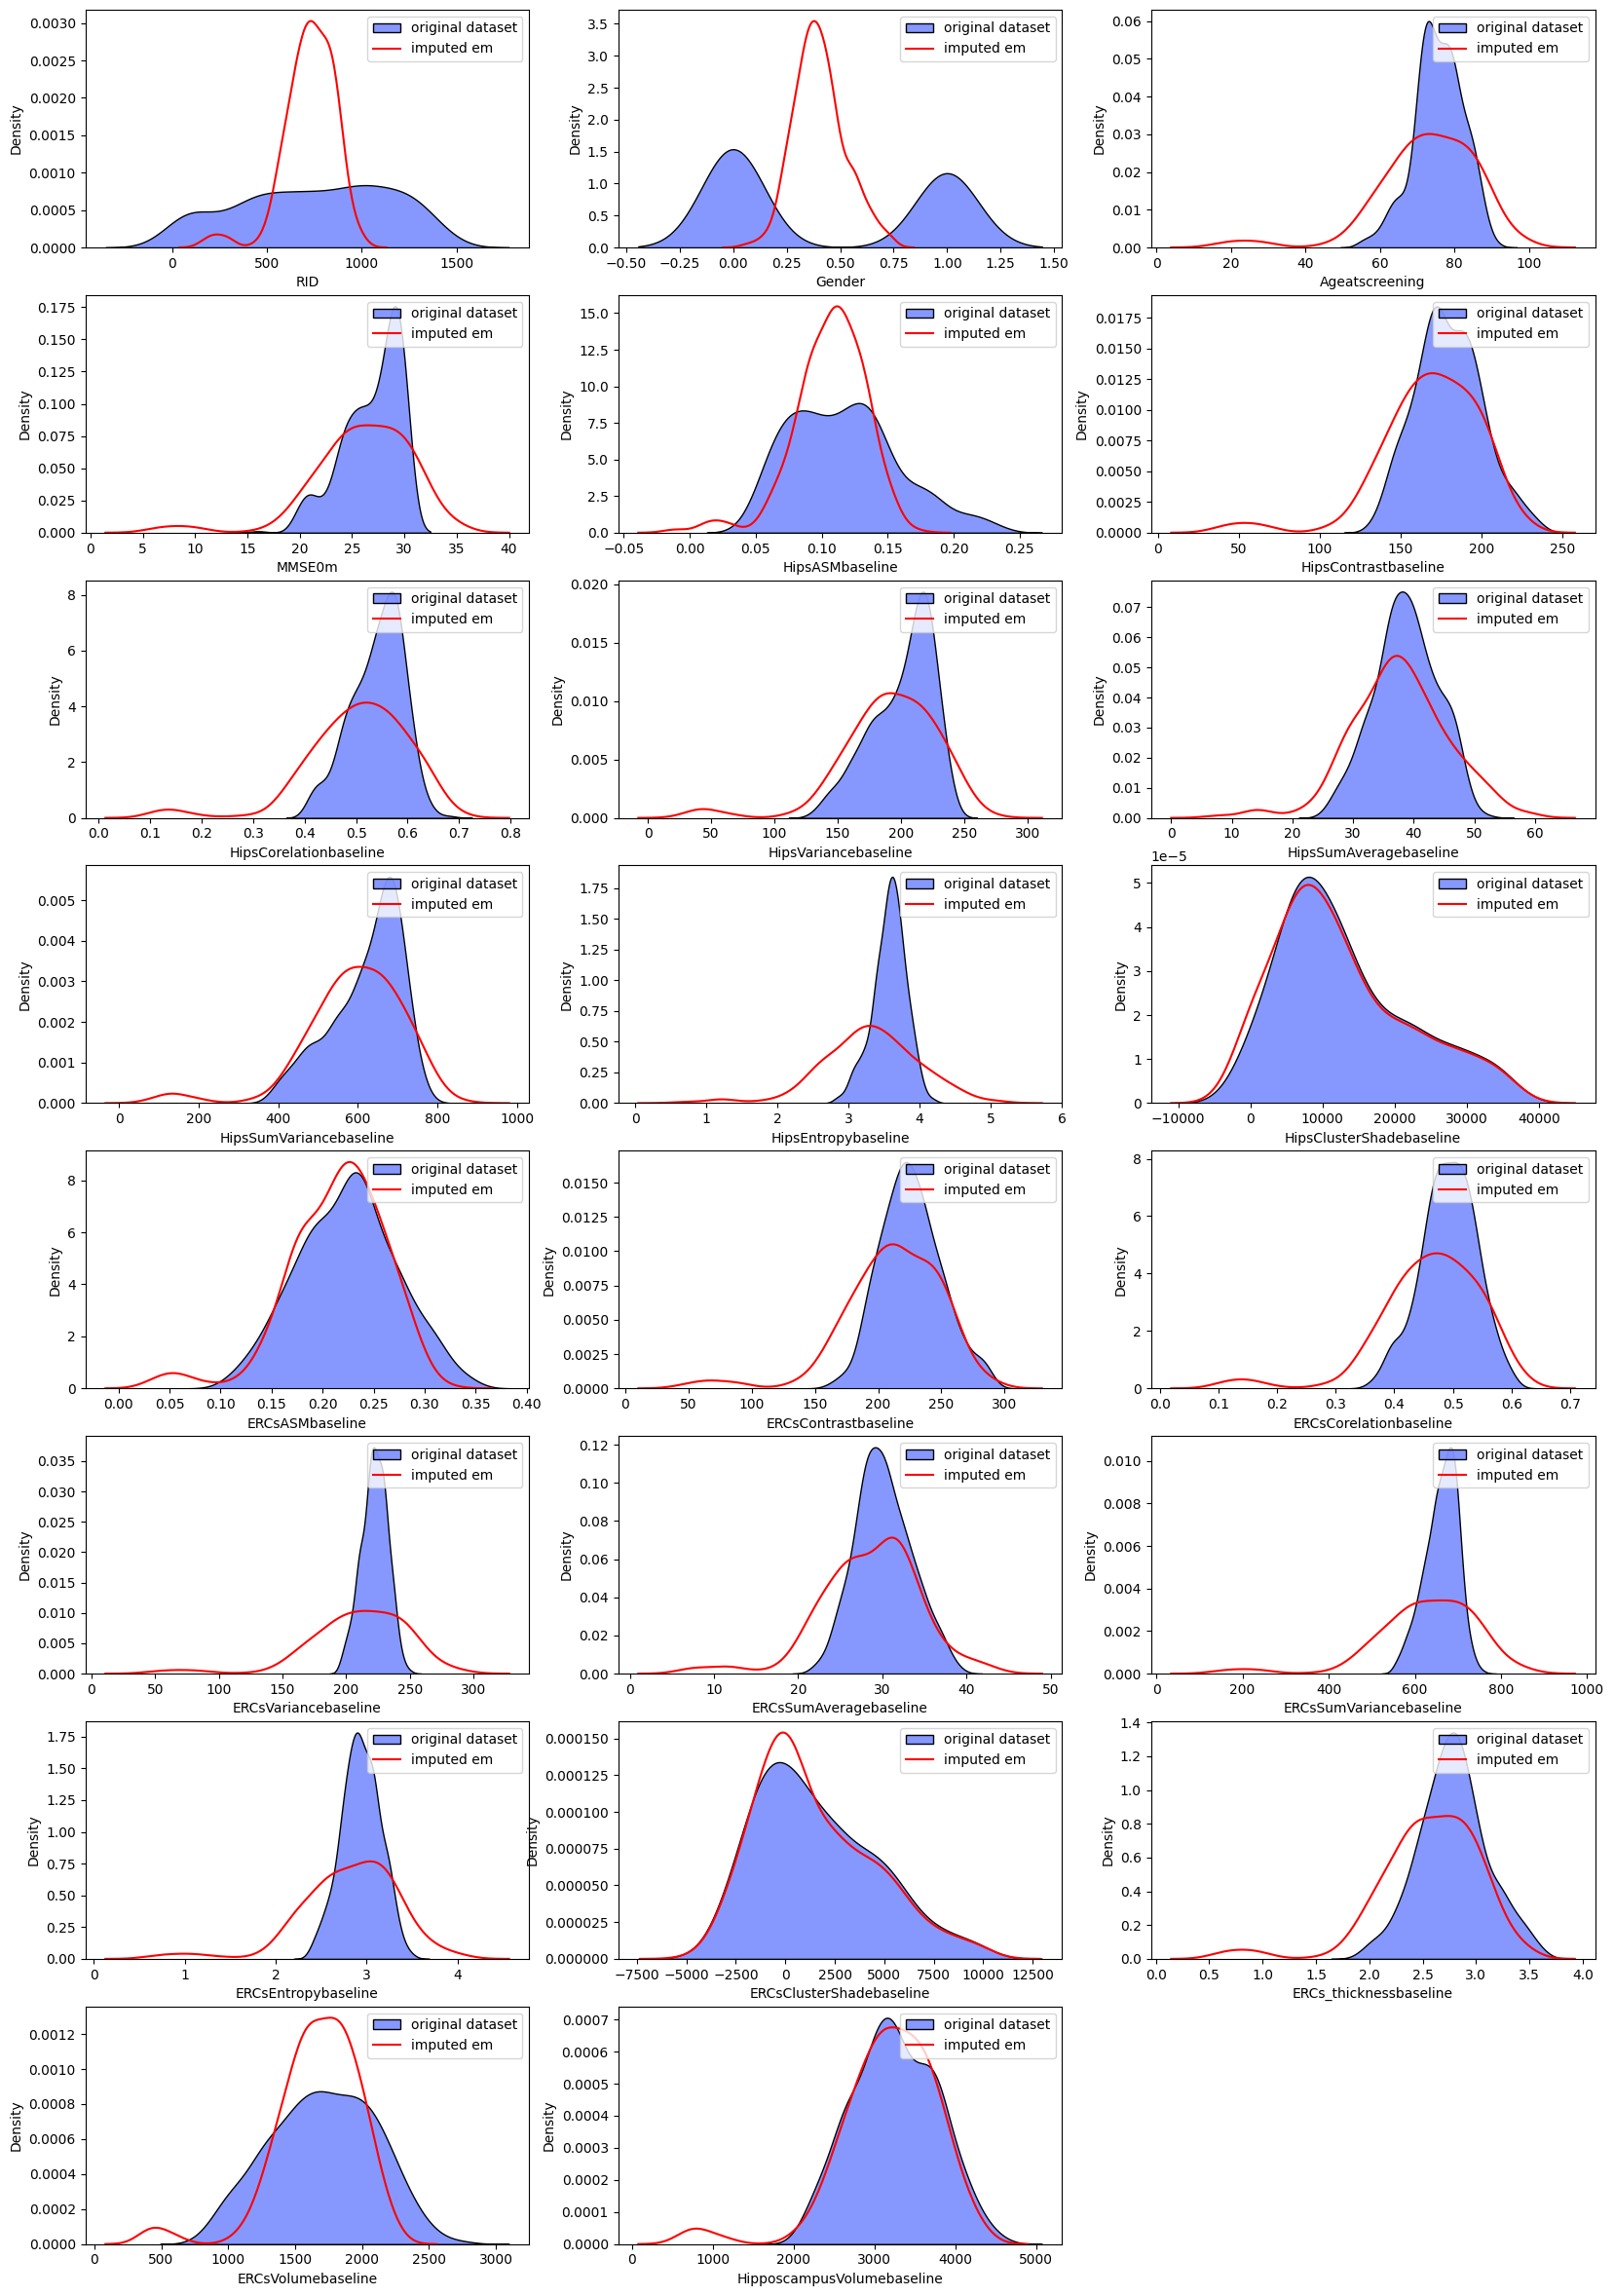

In [36]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train[X_train.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_imputed_df[X_train_imputed_df.columns[i]], color= "red")
    
    labels = ['original dataset', 'imputed em']
    plt.legend(labels, loc='upper right')

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score)

def run_random_forest(X_train, X_test, y_train, y_test):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Get predicted probabilities for ROC AUC
        pred_train_proba = rf.predict_proba(X_train)
        pred_test_proba = rf.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train_norm = rf.predict(X_train)
        pred_test_norm = rf.predict(X_test)
        
        # Calculate ROC-AUC
        roc_score_train = roc_auc_score(y_train, 
                                        pred_train_proba, 
                                        average="weighted", 
                                        multi_class="ovr",
        )
        roc_score_test = roc_auc_score(y_test,
                                    pred_test_proba,  
                                    average="weighted", 
                                    multi_class="ovr",
        )
        
        # Calculate accuracies
        accuracy_train = accuracy_score(y_train, pred_train_norm)
        accuracy_test = accuracy_score(y_test, pred_test_norm)
        
        # Print results
        print(f"Train ROC-AUC: {roc_score_train}")
        print(f"Train Accuracy: {accuracy_train}")
        print(f"Test ROC-AUC: {roc_score_test}")
        print(f"Test Accuracy: {accuracy_test}")

In [31]:
run_random_forest(X_train, X_test, y_train, y_test)

Train ROC-AUC: 0.9798360133361196
Train Accuracy: 0.8705882352941177
Test ROC-AUC: 0.81421118444227
Test Accuracy: 0.5355191256830601


In [32]:
run_random_forest(X_train_imputed, X_test_imputed, y_train, y_test)

Train ROC-AUC: 0.8750395463578706
Train Accuracy: 0.6658823529411765
Test ROC-AUC: 0.6142533200310984
Test Accuracy: 0.36065573770491804
